In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
print(os.listdir("../input"))  # input内のファイル表示
import warnings
warnings.filterwarnings("ignore")  # 原因不明の実行エラーが出たら邪魔だから表示させない

# rcParamsは辞書だけど、これを書き換えれば全体の設定が変わるよ
plt.rcParams['figure.figsize'] = (16, 9)
sns.set_palette('gist_earth')  # snsで使うカラーパレット指定


['.DS_Store', 'gender_submission.csv', 'test.csv', 'train.csv']


In [7]:
# read datasets
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
# Merge 2 dataset for EDA and feature Engineering
# Explanatory Data Analysis（略してEDA）とは、データの特徴を探求し、
# 構造を理解することを目的としたデータサイエンスの最初の一歩
df_train.head(10)
df_train.head(10)
full = pd.concat([df_train, df_test], axis=0, sort=True)
full.head(10)
# set passengerId as index
full.set_index('PassengerId', drop=False, inplace=True)
train = full[:891]
# inplaceは元の配列を変更するかどうか、dropはindex列を捨てるかどうか
full.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
6,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
7,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
8,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
9,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742


In [9]:
# idenfity missing values
nan = full.isnull() # dataframeの中で、
# nuneかどうかそれぞれのデータについて判定、TorFを格納
nan.head(10)
type(nan)

pandas.core.frame.DataFrame

In [11]:
# idenfity missing values
nan = full.isnull().sum()  # sum()はDataframeに対しては列ごとに合計を計算 
nan.head(10)

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
dtype: int64

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Survived'], dtype='object')


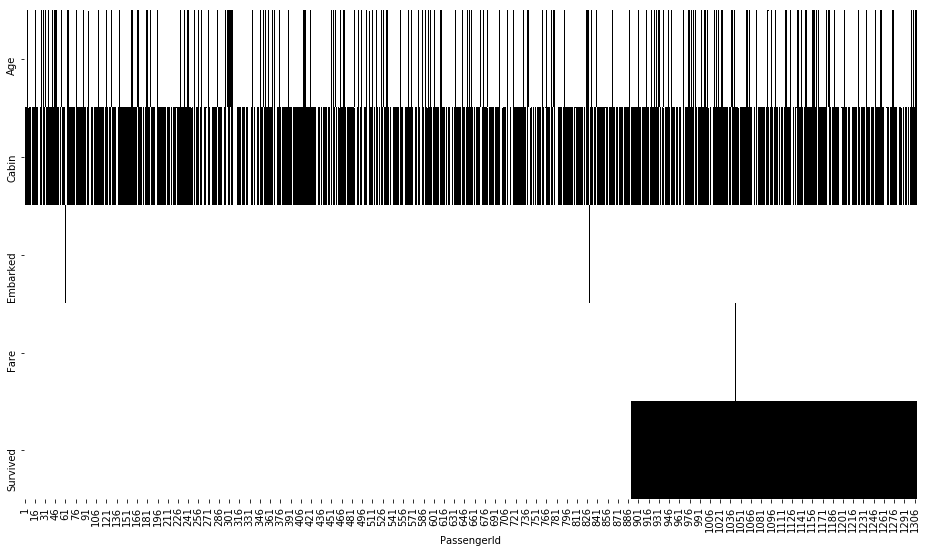

In [19]:
nan = full.isnull().sum()
idx_nan = nan.mask(nan==0).dropna().index  
print(idx_nan)
# mask()は　条件に合わないところは、オリジナルの値を維持。
# dropnaで0もしくはNaNを除く.indexでindexのみのリスト作成
# cbar:カラーバーをどこに置くか。今回なし
# cmapはカラーマップか。binaryだと2色なんだろな
sns.heatmap(full[idx_nan].transpose().isnull(), cmap='binary', cbar=False)
# 欠損値を持つデータについて、
# transpose()転置

In [17]:
nan[idx_nan].drop('Survived').sort_values() # 整列。survived落とす

Fare           1
Embarked       2
Age          263
Cabin       1014
dtype: int64

In [20]:
# data cleaning
# ticket and cabin gives us information about where passengers is
# 先ずはチケットから
np.sort(full['Ticket'].unique())  # uniqueは要素の重複をなくしたものを返す

array(['110152', '110413', '110465', '110469', '110489', '110564',
       '110813', '111163', '111240', '111320', '111361', '111369',
       '111426', '111427', '111428', '112050', '112051', '112052',
       '112053', '112058', '112059', '112277', '112377', '112378',
       '112379', '112901', '113028', '113038', '113043', '113044',
       '113050', '113051', '113054', '113055', '113056', '113059',
       '113501', '113503', '113505', '113509', '113510', '113514',
       '113572', '113760', '113767', '113773', '113776', '113778',
       '113780', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113790', '113791', '113792', '113794',
       '113795', '113796', '113798', '113800', '113801', '113803',
       '113804', '113806', '113807', '11668', '11751', '11752', '11753',
       '11755', '11765', '11767', '11769', '11770', '11771', '11774',
       '11778', '11813', '11967', '1222', '12233', '12460', '12749',
       '13049', '13050', '13213', '13214', '13236',

In [ ]:
def parse_ticket(str1):
    '''
    function to parse the letter part of the ticket code
    '''
    # \dは数字\d{4,7}で4から7桁の数字
    # |はor
    m = re.search(r'(.*)(\s\d|\s\d{4,7}$)', str1)
    # 文字\s数字or
    s = re.search(r'[A-Z]+', str1)